In [1]:
# ----------------------------
# Setup & Install Dependencies
# ----------------------------
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
-f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip install -q torch-geometric
!pip install -q spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 118.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# 1. Mount Drive and Import
from google.colab import drive
import os, json, pickle
import torch
import torch.nn as nn
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import spacy

In [17]:

# 2. Paths and Config
DRIVE_ROOT       = '/content/drive'
drive.mount(DRIVE_ROOT)

# Input JSONs and features
TEST_JSON        = os.path.join(DRIVE_ROOT, 'MyDrive/Gemini_Captions/kg_test_augmented.json')
FEATS_TEST_PATH  = os.path.join(DRIVE_ROOT, 'MyDrive/gemini_models/kg_models2/precomputed_feats_test.pt')

# Graph and Model artifacts
KG_PATH          = os.path.join(DRIVE_ROOT, 'MyDrive/gemini_models/kg_models2/kg_graph_aug.gpickle')
WEIGHTS_PATH     = os.path.join(DRIVE_ROOT, 'MyDrive/gemini_models/kg_models2/checkpoints/best_model.pth')

# Output JSON for predictions
OUTPUT_PRED_JSON = os.path.join(DRIVE_ROOT, 'MyDrive/Gemini_Captions/kg_captions2/test_predictions.json')
DEVICE           = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# 5. Dataset and DataLoader for Test Set
nlp = spacy.load('en_core_web_sm')

# 3. Load Knowledge Graph
import pickle
with open(KG_PATH, "rb") as f:
    G = pickle.load(f)

node_to_idx = {n:i for i,n in enumerate(G.nodes())}
deg = dict(G.degree()); max_deg = max(deg.values()) if deg else 1
edge_index = torch.tensor([[node_to_idx[u] for u,v in G.edges()],
                           [node_to_idx[v] for u,v in G.edges()]], dtype=torch.long)
x_feat = torch.tensor([[deg[n]/max_deg] for n in G.nodes()], dtype=torch.float)
data_graph = Data(x=x_feat, edge_index=edge_index)

# 4. Triplet Extraction Utility
def extract_triplets(caption, nlp):
    doc = nlp(caption.lower())
    triples = []
    for token in doc:
        if token.dep_ in ('amod','acomp') and token.head.pos_=='NOUN':
            triples.append((token.head.lemma_, token.lemma_))
        elif token.dep_=='attr' and token.head.pos_=='NOUN':
            triples.append((token.head.lemma_, token.lemma_))
        elif token.dep_=='nsubj' and token.head.pos_ in ('VERB','AUX'):
            triples.append((token.text, token.head.lemma_))
    return triples



In [18]:
# 5. Load Test Data
with open(TEST_JSON) as f:
    test_data = json.load(f)

# 6. Load or Compute Test Features
if os.path.exists(FEATS_TEST_PATH):
    print(f"✅ Loading precomputed test features from {FEATS_TEST_PATH}")
    all_feats_test = torch.load(FEATS_TEST_PATH)
else:
    print("🔄 Computing test features...")
    from multiprocessing import Pool, cpu_count
    from sentence_transformers import SentenceTransformer, util
    import numpy as np
    from nltk.corpus import wordnet as wn

    # Define hazard_keywords dict (as used during training)
    hazard_keywords = {
        "low": [
            ("clear road", 1.0), ("dry road", 1.0), ("daytime", 1.0), ("straight road", 1.0),
            ("good visibility", 1.0), ("no traffic", 1.0), ("open road", 1.0), ("well-lit", 1.0),
            ("sunny", 1.0), ("flat terrain", 1.0), ("light traffic", 1.0), ("wide road", 1.0)
        ],
        "medium": [
            ("moderate visibility", 1.5), ("residential area", 1.5), ("curved road", 1.5),
            ("slightly wet", 1.5), ("light rain", 1.5), ("children nearby", 1.5),
            ("cyclist", 1.5), ("school zone", 1.5), ("urban traffic", 1.5),
            ("construction zone", 1.6), ("intersections", 1.6), ("speed bumps", 1.5)
        ],
        "high": [
            ("poor visibility", 2.0), ("fog", 2.0), ("heavy rain", 2.1), ("pedestrian ahead", 2.2),
            ("jaywalking", 2.2), ("nighttime", 2.0), ("icy road", 2.3), ("sharp turn", 2.1),
            ("blind spot", 2.1), ("narrow lane", 2.0), ("heavy traffic", 2.0),
            ("obstruction", 2.1), ("collision", 2.5), ("emergency vehicle", 2.2), ("road closed", 2.3)
        ]
    }

    # Utility Functions
    def keyword_hazard_score(text):
        txt = text.lower()
        return torch.tensor([sum(txt.count(kw) for kw, _ in hazard_keywords[lvl])
                             for lvl in ("low", "medium", "high")], dtype=torch.float)

    def graph_context_score(text):
        nodes = {u for u, _ in extract_triplets(text, nlp)} | {v for _, v in extract_triplets(text, nlp)}
        vals = [deg[n] / max_deg for n in nodes if n in deg]
        return torch.tensor([np.mean(vals) if vals else 0.0] * 3, dtype=torch.float)

    def compute_kg_feat(text):
        return torch.cat([keyword_hazard_score(text), graph_context_score(text)])

    # Initialize Sentence Embedder
    sem_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Prepare semantic level embeddings
    semantic_levels = {
        lvl: sem_model.encode([kw for kw, _ in hazard_keywords[lvl]], convert_to_tensor=True)
        for lvl in hazard_keywords
    }

    # Compute features
    texts = [item['description'] for item in test_data]

    # Keyword + graph features
    with Pool(cpu_count()) as p:
        kg_feats = list(p.imap(compute_kg_feat, texts))

    # Semantic features
    sem_feats = sem_model.encode(texts, convert_to_tensor=True, show_progress_bar=True)

    all_feats_test_list = []
    for i, emb in enumerate(sem_feats):
        sims = [util.cos_sim(emb, semantic_levels[lvl]).max().item() for lvl in semantic_levels]
        norm = sum(sims) or 1
        sims = torch.tensor([s / norm for s in sims], dtype=torch.float)
        all_feats_test_list.append(torch.cat([kg_feats[i], sims]))

    all_feats_test = torch.stack(all_feats_test_list)

    # Save for future runs
    torch.save(all_feats_test, FEATS_TEST_PATH)
    print(f"✅ Saved computed test features to {FEATS_TEST_PATH}")


✅ Loading precomputed test features from /content/drive/MyDrive/gemini_models/kg_models2/precomputed_feats_test_dup.pt


In [19]:

class TestCaptionDataset(Dataset):
    def __init__(self, data, feats, node_to_idx, nlp):
        self.data = data
        self.feats = feats
        self.node_to_idx = node_to_idx
        self.nlp = nlp
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        item = self.data[idx]
        desc = item['description']
        triples = extract_triplets(desc, self.nlp)
        nodes = [self.node_to_idx[n] for u,v in triples for n in (u,v) if n in self.node_to_idx]
        if not nodes:
            nodes = [0]
        return nodes, self.feats[idx], item.get('filename', f"img_{idx}")

# Load test annotations and features
with open(TEST_JSON) as f:
    test_data = json.load(f)
all_feats_test = torch.load(FEATS_TEST_PATH)

test_ds = TestCaptionDataset(test_data, all_feats_test, node_to_idx, nlp)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=lambda b: (list(zip(*b))[0], torch.stack(list(zip(*b))[1]), list(zip(*b))[2]))

In [20]:

# 6. Define and Load Model
class GraphSAGEClassifier(nn.Module):
    def __init__(self, in_c, hidden_c, out_c, dropout=0.3):
        super().__init__()
        self.sage1 = SAGEConv(in_c, hidden_c)
        self.sage2 = SAGEConv(hidden_c, hidden_c)
        self.sage3 = SAGEConv(hidden_c, hidden_c)
        self.attn_weights = nn.Parameter(torch.randn(hidden_c,1))
        self.mlp = nn.Sequential(
            nn.Linear(hidden_c + 9, 64), nn.LayerNorm(64), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(64, out_c)
        )
    def forward(self, node_ids_batch, heuristics, graph):
        x, edge_index = graph.x, graph.edge_index
        x = self.sage1(x, edge_index).relu()
        x = self.sage2(x, edge_index).relu()
        x = self.sage3(x, edge_index).relu()
        node_feats = []
        for node_ids in node_ids_batch:
            embeds = x[node_ids]
            scores = embeds @ self.attn_weights
            attn = torch.softmax(scores, dim=0)
            node_feats.append((attn * embeds).sum(dim=0))
        graph_feats = torch.stack(node_feats)
        combined = torch.cat([graph_feats, heuristics.to(DEVICE)], dim=1)
        return self.mlp(combined)

model = GraphSAGEClassifier(1,128,3).to(DEVICE)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=DEVICE))
model.eval()




GraphSAGEClassifier(
  (sage1): SAGEConv(1, 128, aggr=mean)
  (sage2): SAGEConv(128, 128, aggr=mean)
  (sage3): SAGEConv(128, 128, aggr=mean)
  (mlp): Sequential(
    (0): Linear(in_features=137, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [21]:
# 7. Inference and Save to JSON
ratings = ['low','medium','high']
preds = []
with torch.no_grad():
    for nodes, heur, fnames in tqdm(test_loader, desc='Inference'):
        heur = heur.to(DEVICE)
        out = model(nodes, heur, data_graph.to(DEVICE))
        labs = out.argmax(dim=1).cpu().tolist()
        for fname, lab in zip(fnames, labs):
            preds.append({'filename': fname, 'predicted_rating': ratings[lab]})

# Write predictions
with open(OUTPUT_PRED_JSON, 'w') as f:
    json.dump(preds, f, indent=4)
print(f"✅ Saved {len(preds)} predictions to {OUTPUT_PRED_JSON}")

Inference:   0%|          | 0/25 [00:00<?, ?it/s]

✅ Saved 1539 predictions to /content/drive/MyDrive/Gemini_Captions/kg_captions2/test_predictions_original.json


Classification Report:

              precision    recall  f1-score   support

         low       0.67      0.30      0.42       587
      medium       0.31      0.55      0.40       146
        high       0.63      0.79      0.70       806

    accuracy                           0.58      1539
   macro avg       0.54      0.55      0.50      1539
weighted avg       0.61      0.58      0.56      1539



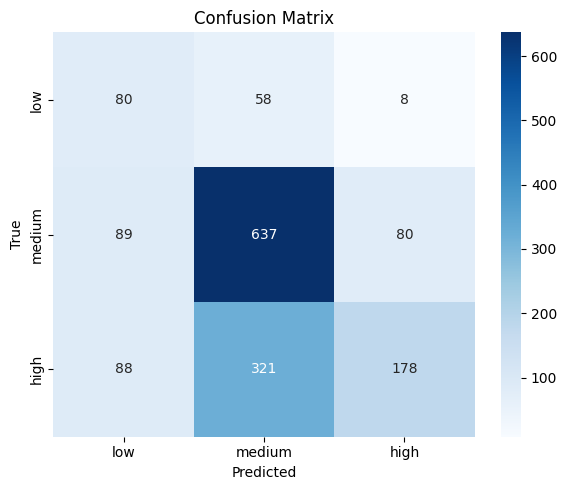

In [22]:
# 10. Evaluation Metrics and Plots
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true & predicted labels in order
true = [item['hazard_rating'] for item in test_data]
pred_labels = [p['predicted_rating'] for p in preds]

# Classification Report
print("Classification Report:\n")
print(classification_report(true, pred_labels, target_names=["low", "medium", "high"]))

# Confusion Matrix
cm = confusion_matrix(true, pred_labels, labels=["low", "medium", "high"])
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
